In [2]:
using MPSTime
using Random
using Plots
using PrettyTables

rng = Xoshiro(1)

d = 5
chi_max = 40

opts = MPSOptions(d = d, chi_max = chi_max, sigmoid_transform = false)

ntimepoints = 7
ntrain_instances = 1000
ntest_instances = 500
period = 10
sigma = 0.05;
final_multiplier = 20;

In [3]:
X_train, _ = trendy_sine(ntimepoints, ntrain_instances; sigma = sigma, rng = rng,slope = 0, period = period);
X_test, _ = trendy_sine(ntimepoints, ntest_instances; sigma = sigma, rng = rng,slope = 0, period = period);
Final, _ = trendy_sine(ntimepoints*final_multiplier, 1; sigma = sigma, rng = rng, slope = 0, period = period);

In [4]:
print(size(X_test))

(500, 7)

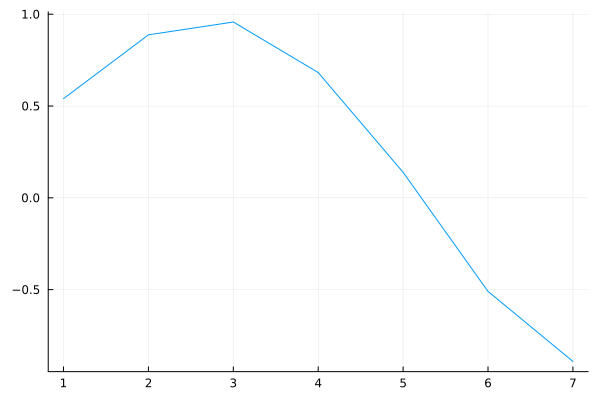

In [5]:
plot(X_train[100, :], legend = false)

(1, 140)

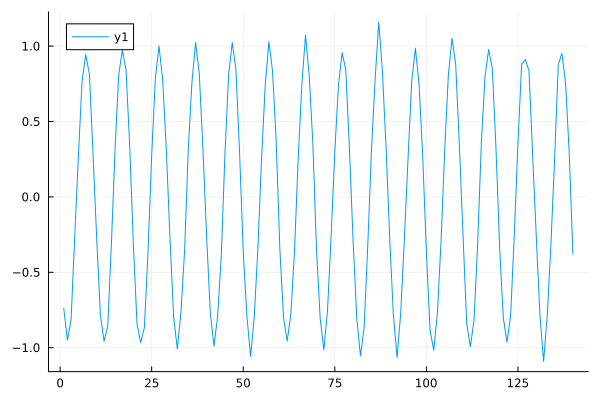

In [6]:
print(size(Final))
plot(Final[1,:])

In [7]:
mps, info, test_states = fitMPS(X_train, opts);

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
Using 1 iterations per update.
Training KL Div. 8.867374874123504 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/5]
Backward sweep finished.
Starting forward sweep: [1/5]
Finished sweep 1. Time for sweep: 24.51s
Training KL Div. 4.8551946003535065 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/5]
Backward sweep finished.
Starting forward sweep: [2/5]
Finished sweep 2. Time for sweep: 2.89s
Training KL Div. 2.5339770119673224 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/5]
Backward sweep finished.
Starting forward sweep: [3/5]
Finished sweep 3. Time for sweep: 2.14s
Training KL Div. 1.2247858325481749 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/5]
Bac

In [8]:
class = 0
instance_idx = 2
impute_sites = [ntimepoints]
method = :ITS
imp = init_imputation_problem(mps,X_test);
num_trajectories = 2
rejection_thresh = 0.95

Initialising train states.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 1000 training samples and 500 testing samples.
Slicing MPS into individual states...
 - 1 class(es) were detected.
 - Time independent encoding - Legendre - detected.
 - d = 5, chi_max = 40
Re-encoding the training data to get the encoding arguments...

 Created 1 ImputationProblem struct(s) containing class-wise mps and test samples.


0.95

In [9]:
# imputed_ts, pred_err, target_ts, stats, nice_plots = MPS_impute(imp, class, instance_idx, impute_sites, method; plot_fits = true);
imputed_ts, pred_err, target_ts, stats, nice_plots = MPS_impute(imp, class, instance_idx, impute_sites, method; plot_fits = true, num_trajectories = num_trajectories, rejection_threshold = rejection_thresh);


In [9]:
pretty_table(stats[1]; header = ["Metric", "Value"], header_crayon = crayon"yellow bold", tf = tf_unicode_rounded)

╭─────────┬──────────╮
│  Metric │    Value │
├─────────┼──────────┤
│     MAE │ 0.117086 │
│    MAPE │ 0.139911 │
│  NN_MAE │ 0.146526 │
│ NN_MAPE │  0.17509 │
╰─────────┴──────────╯


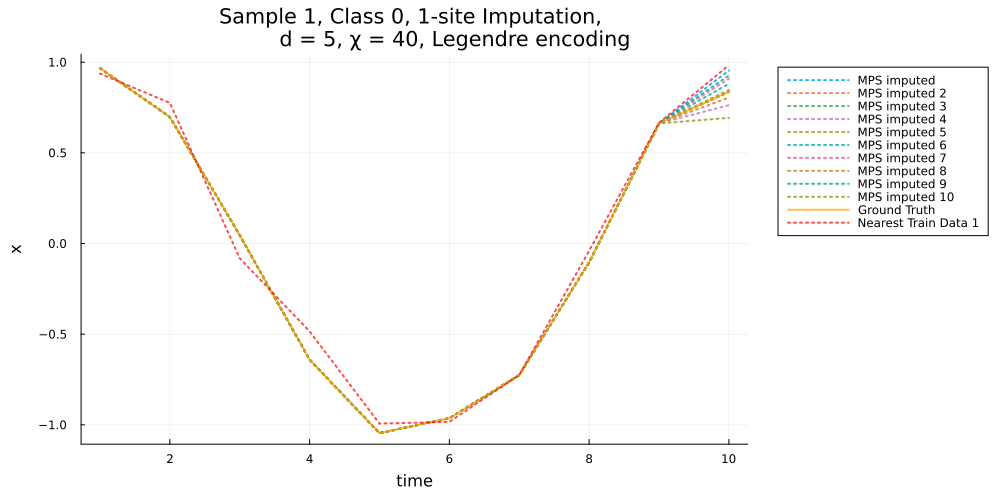

In [10]:
plot(nice_plots...)
# savefig(p, "eg.png")

In [3]:
macro noprint(expr)
    quote
        let so = stdout
            redirect_stdout(devnull)
            res = $(esc(expr))
            redirect_stdout(so)
            res
        end
    end
end;

In [ ]:
class = 0
instance_idx = 1
impute_sites = [ntimepoints]
method = :median

num_forecasts = ntimepoints * final_multiplier - ntimepoints - 1

initial_data = copy(Final[:, 1:ntimepoints])

# initial_data = reshape(Final[:, 1:ntimepoints], num_trajectories, :)

guesses = Array{Float64, 2}(undef, num_trajectories, ntimepoints * final_multiplier)

guesses[:, 1:ntimepoints] .= initial_data
guesses[:, ntimepoints+1:end] .= 0.0

current_data = guesses[:, collect(1:ntimepoints)]

println("Current data size: ", size(current_data), " ", typeof(current_data))
println("Initial data size: ", size(initial_data), " ", initial_data)
println("Impute sites: ", impute_sites)
println("Guesses size: ", size(guesses))

println("BEGIN LOOP")

data_steps = Dict{Int, Array{Tuple{Array{Float64}, Array{Float64}}, 1}}()

saved_mps = Vector{Any}(undef, num_trajectories)

for traj in 1:num_trajectories

    rng = Xoshiro(traj)

    X_train, _ = @noprint trendy_sine(ntimepoints, ntrain_instances; sigma = sigma, rng = rng,slope = 0, period = period);

    mps, _, _ = @noprint fitMPS(X_train, opts);

    saved_mps[traj] = mps  

end

println("Completed MPS")

for forecast_idx in collect(ntimepoints * final_multiplier - num_forecasts:ntimepoints*final_multiplier-1)
    
    println("Forecasting ", forecast_idx)

    x_values = reshape(collect(forecast_idx - ntimepoints:forecast_idx - 1), 1, :)

    trajectory_results = Array{Tuple{Array{Float64}, Array{Float64}}, 1}(undef, num_trajectories)
    
    for traj in 1:num_trajectories
        imp = @noprint init_imputation_problem(saved_mps[traj], current_data[traj:traj, :]; verbosity = 0)

        imputed_ts, _, _, _, _ = @noprint MPS_impute(imp, class, instance_idx, impute_sites, method)

        guesses[traj, forecast_idx] = imputed_ts[1][ntimepoints]

        trajectory_results[traj] = (x_values, current_data[traj, :])
        
        current_data[traj, :] = guesses[traj, forecast_idx - ntimepoints + 1:forecast_idx]
        
    end

    data_steps[forecast_idx] = trajectory_results
end

In [4]:
class = 0
instance_idx = 1
impute_sites = [ntimepoints]
method = :ITS
num_trajectories = 7
rejection_thresh = 0.5

num_forecasts = ntimepoints * final_multiplier - ntimepoints - 1

initial_data = copy(Final[:, 1:ntimepoints])

# initial_data = reshape(Final[:, 1:ntimepoints], num_trajectories, :)

guesses = Array{Float64, 2}(undef, num_trajectories, ntimepoints * final_multiplier)

guesses[:, 1:ntimepoints] .= initial_data
guesses[:, ntimepoints+1:end] .= 0.0

current_data = guesses[:, collect(1:ntimepoints)]

println("Current data size: ", size(current_data), " ", typeof(current_data))
println("Initial data size: ", size(initial_data), " ", initial_data)
println("Impute sites: ", impute_sites)
println("Guesses size: ", size(guesses))

println("BEGIN LOOP")

data_steps = Dict{Int, Array{Tuple{Array{Float64}, Array{Float64}}, 1}}()

saved_mps = Vector{Any}(undef, num_trajectories)

for traj in 1:num_trajectories

    rng = Xoshiro(traj)

    X_train, _ = @noprint trendy_sine(ntimepoints, ntrain_instances; sigma = sigma, rng = rng,slope = 0, period = period);

    mps, _, _ = @noprint fitMPS(X_train, opts);

    saved_mps[traj] = mps  

end

println("Completed MPS")

for forecast_idx in collect(ntimepoints * final_multiplier - num_forecasts:ntimepoints*final_multiplier-1)
    
    println("Forecasting ", forecast_idx)

    x_values = reshape(collect(forecast_idx - ntimepoints:forecast_idx - 1), 1, :)

    trajectory_results = Array{Tuple{Array{Float64}, Array{Float64}}, 1}(undef, num_trajectories)
    
    for traj in 1:num_trajectories
        imp = @noprint init_imputation_problem(saved_mps[traj], current_data[traj:traj, :]; verbosity = 0)

        imputed_ts, _, _, _, _ = @noprint MPS_impute(imp, class, instance_idx, impute_sites, method; 
                                            plot_fits = true, num_trajectories = num_trajectories, rejection_threshold = rejection_thresh)

        guesses[traj, forecast_idx] = imputed_ts[1][ntimepoints]

        trajectory_results[traj] = (x_values, current_data[traj, :])
        
        current_data[traj, :] = guesses[traj, forecast_idx - ntimepoints + 1:forecast_idx]
        
    end

    data_steps[forecast_idx] = trajectory_results
end


Current data size: (7, 7) Matrix{Float64}
Initial data size: (1, 7) [-0.7379160574630252 -0.949123528666481 -0.8146648701330821 -0.259675868055291 0.274661506216633 0.7687170495734091 0.9434733508829697]
Impute sites: [7]
Guesses size: (7, 140)
BEGIN LOOP
Completed MPS
Forecasting 8
Forecasting 9
Forecasting 10
Forecasting 11
Forecasting 12
Forecasting 13
Forecasting 14
Forecasting 15
Forecasting 16
Forecasting 17
Forecasting 18
Forecasting 19
Forecasting 20
Forecasting 21
Forecasting 22
Forecasting 23
Forecasting 24
Forecasting 25
Forecasting 26
Forecasting 27
Forecasting 28
Forecasting 29
Forecasting 30
Forecasting 31
Forecasting 32
Forecasting 33
Forecasting 34
Forecasting 35
Forecasting 36
Forecasting 37
Forecasting 38
Forecasting 39
Forecasting 40
Forecasting 41
Forecasting 42
Forecasting 43
Forecasting 44
Forecasting 45
Forecasting 46
Forecasting 47
Forecasting 48
Forecasting 49
Forecasting 50
Forecasting 51
Forecasting 52
Forecasting 53
Forecasting 54
Forecasting 55
Forecasting 

In [5]:
print(data_steps)

Dict{Int64, Vector{Tuple{Array{Float64}, Array{Float64}}}}(56 => [([49.0 50.0 51.0 52.0 53.0 54.0 55.0], [0.11083265424008659, 0.6698561434112507, -0.9698299910777107, 0.735336776410739, 0.27221222847641435, 1.0110752575699322, -0.9866645509800613]), ([49.0 50.0 51.0 52.0 53.0 54.0 55.0], [0.9907636016501686, 0.7793774681733996, 0.3589727259148008, -0.09390092644582992, -0.5019043488737915, -0.7377549041982723, -1.0520719922693298]), ([49.0 50.0 51.0 52.0 53.0 54.0 55.0], [0.607662623385876, 0.8811047100706382, 1.0741983307363963, -0.4753458123287946, 0.4158555138208586, -0.3139471469631093, -0.8452762315691296]), ([49.0 50.0 51.0 52.0 53.0 54.0 55.0], [-0.09277658792817411, -0.9289875169783353, -0.5085998812683031, 0.5764262241514369, 0.9832378671715012, -0.9795463863064905, 0.9893236569980388]), ([49.0 50.0 51.0 52.0 53.0 54.0 55.0], [0.028272161833224452, 0.674494506821957, 0.5924796659951881, 1.035883063419247, -1.033143205371469, 0.5259350309276984, 0.4805481772662823]), ([49.0 50

In [86]:
using Plots.PlotMeasures

color_palette = Plots.palette(:copper, num_trajectories)
trajectory_colors = Dict(i => color_palette[i] for i in 1:num_trajectories);

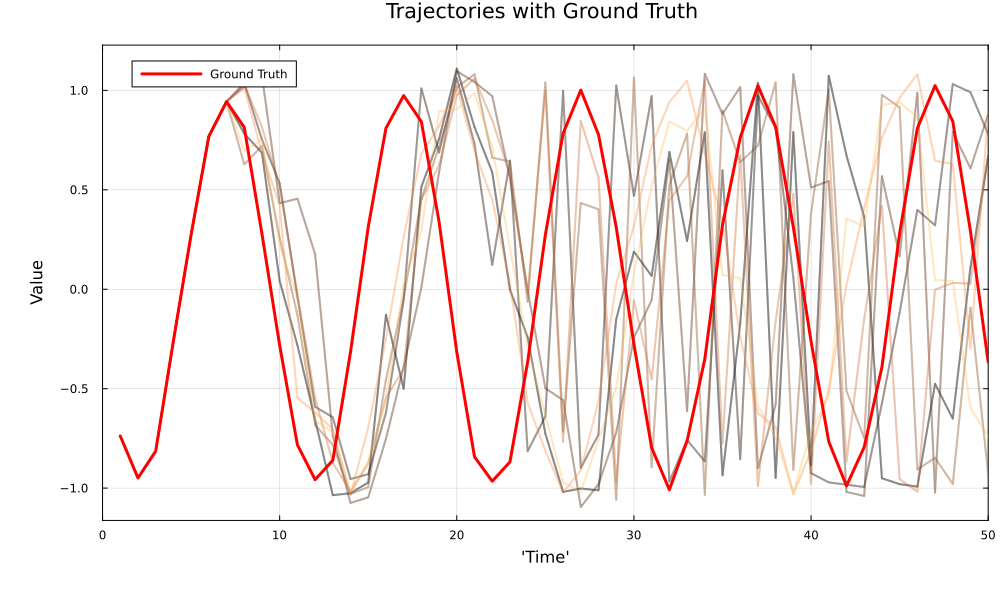

In [98]:
p = plot(title="Trajectories with Ground Truth ", xlabel="'Time'", ylabel="Value", legend = :topleft, size = (1000, 600)
            , framestyle=:box, bottom_margin = 10mm, left_margin = 10mm, top_margin = 5mm)

for (key, traj_list) in data_steps
    println(key)
    for (i,(x_vals, current_vals)) in enumerate(traj_list)
        # # print(size(x_vals), " ", size(current_vals))
        # if (i == 1)
        #     plot!(x_vals[:], current_vals[:], alpha = 0.5, color = "gold", lw = 2, label = "Example traj")
        # end
        println(i)
        # plot!(x_vals[:], current_vals[:], alpha = 0.1, color="gray", lw = 2)

        plot!(x_vals[:], current_vals[:], alpha = 0.1, color=trajectory_colors[i], lw = 2, label = "")
    end
end


plot!(Final[1,:], c=:red, xlims = (0,50), lw = 3, label = "Ground Truth")

display(p)

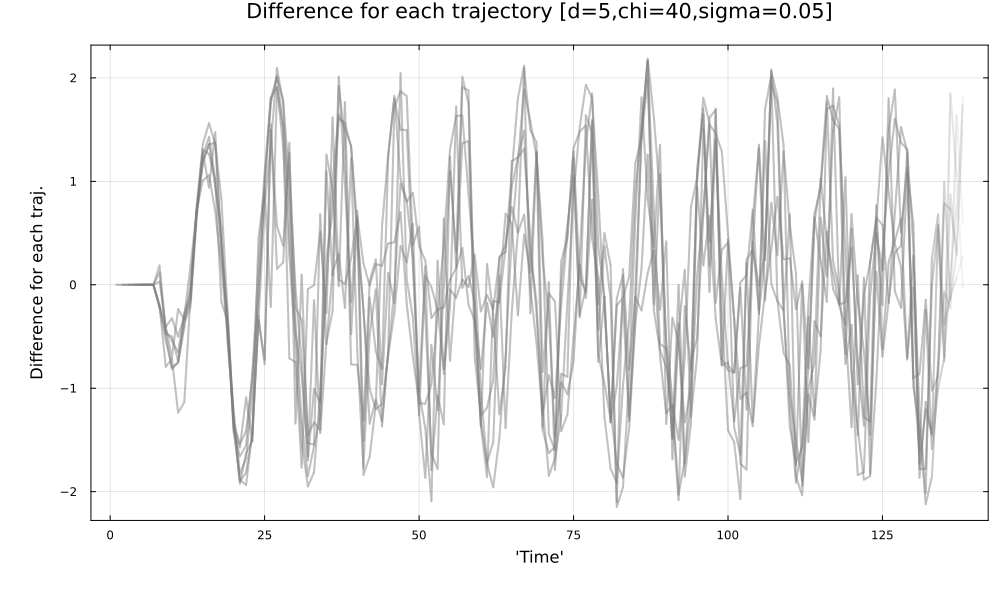

In [96]:
ploting = plot(legend=false, title="Difference for each trajectory [d=$d,chi=$chi_max,sigma=$sigma]", xlabel="'Time'", ylabel="Difference for each traj.", size = (1000, 600)
, framestyle=:box, bottom_margin = 10mm, left_margin = 10mm, top_margin = 5mm)

for (key, traj_list) in data_steps

    for (i,(x_vals, current_vals)) in enumerate(traj_list)

        # println(size(Final[Int.(x_vals)]), " ", size(current_vals))

        diff = [Final[1, Int(x)] - y for (x, y) in zip(x_vals, current_vals)]
        
        plot!(x_vals[:], diff[:], alpha = 0.1, color = "gray", lw = 2)
        #plot!(x_vals[:], diff[:], alpha = 0.1, color=trajectory_colors[i], lw = 2)
    end
end

display(ploting)
#savefig(ploting, "Difference_MPSTime_MSF_d=$d chi=$chi_max ntime=$ntimepoints sigma=$sigma.png")

In [368]:
# phase_shift = 1

# ploting = plot(legend=false, title="Difference d=$d chi=$chi_max MSF", xlabel="'Time'", ylabel="Y-Value", lw=1)

# for (forecast_idx, (x_vals, current_vals)) in data_steps
    
    
#     x_vals_sliced = x_vals[1:end-1] .+ phase_shift
#     current_vals_sliced = current_vals[1:end-1]
    
    
#     diff_vals = Final[1, Int.(x_vals_sliced)] .- current_vals_sliced
    
#     plot!(x_vals_sliced[:], diff_vals[:], lw=1)
# end

# display(ploting)
# # savefig(ploting, "MPSTime_MSF_d=1_chi=50_difference_fixed_period_phase+1.png")

In [369]:
# phase_shift = 2 

# ploting = plot(legend=false, title="Difference d=$d chi=$chi_max MSF", xlabel="'Time'", ylabel="Y-Value", lw=1)

# for (forecast_idx, (x_vals, current_vals)) in data_steps
    
#     x_vals_sliced = x_vals[1:end-1] .+ phase_shift
#     current_vals_sliced = current_vals[1:end-1]
    
#     diff_vals = Final[1, Int.(x_vals_sliced)] .- current_vals_sliced
    
#     plot!(x_vals_sliced[:], diff_vals[:], lw=1)
# end

# display(ploting)
# # savefig(ploting, "MPSTime_MSF_d=1_chi=50_difference_fixed_period_phase+2.png")